# Processing GOES-16 data with Dask & AWS Fargate

This notebook demonstrates how to work with the GOES-16 data available as part of the AWS Public Dataset Program (https://registry.opendata.aws/noaa-goes/).

GOES-16 is the next generation geostationary satellite launched by NOAA since 2017 which provides scan of the Americas every 10 minutes.

### Setting up the environment

In [1]:
%matplotlib inline
import xarray as xr
import boto3
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cartopy, cartopy.crs as ccrs
from botocore import UNSIGNED
from botocore.client import Config

In [3]:
## Define the function to get the url from Amazon S3 for the GOES-16 data
def get_url_for_prefix(prefix):
    s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket = 'noaa-goes16', Prefix = prefix)


    files_mapper = ["s3://noaa-goes16/" + file['Key'] for page in page_iterator for file in page['Contents']]
    return files_mapper[1]

get_url_for_prefix('ABI-L2-CMIPC/2021/295/18/OR_ABI-L2-CMIPC-M6C01')


's3://noaa-goes16/ABI-L2-CMIPC/2021/295/18/OR_ABI-L2-CMIPC-M6C01_G16_s20212951806172_e20212951808545_c20212951809016.nc'

In [5]:
blue_url = get_url_for_prefix('ABI-L2-CMIPC/2021/295/18/OR_ABI-L2-CMIPC-M6C01')
blue_ds = xr.open_dataset(fsspec.open(blue_url, anon=True).open())
blue_ds

<xarray.Dataset>
Dimensions:                                           (y: 3000, x: 5000, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-10-22T18:06:17.2Z
    time_coverage_end:         2021-10-22T18:08:54.5Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e3559d67-7b30-4795-95f8-55f84887ce88

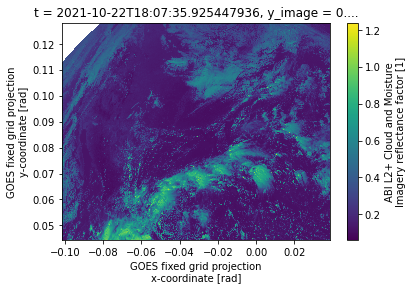

In [6]:
blue_ds['CMI'].plot()

In [7]:
red_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C02')
red_ds = xr.open_dataset(fsspec.open(red_url, anon=True).open())
veggie_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C03')
veggie_ds = xr.open_dataset(fsspec.open(veggie_url, anon=True).open())

In [8]:
display(red_ds['CMI'].values.shape)
display(veggie_ds['CMI'].values.shape)
display(blue_ds['CMI'].values.shape)


(6000, 10000)

(3000, 5000)

(3000, 5000)

In [9]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


In [10]:
red_1km = rebin(red_ds['CMI'].values, [3000, 5000])

In [11]:
red_1km.shape

(3000, 5000)

In [12]:
veggie_1km = veggie_ds['CMI'].values
blue_1km = blue_ds['CMI'].values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


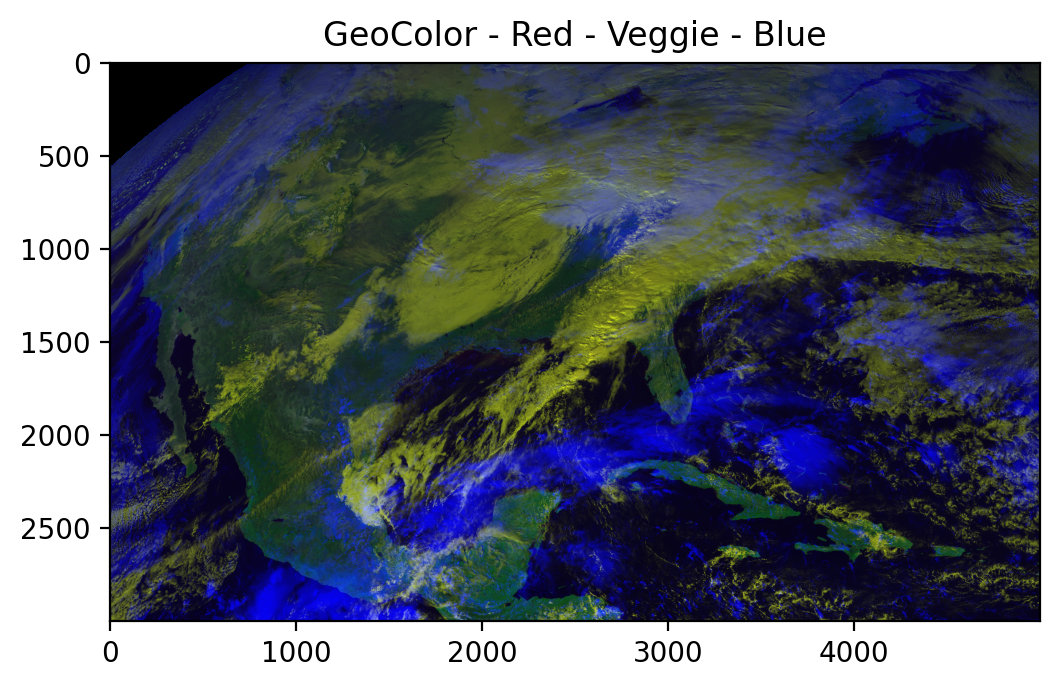

In [13]:
geocolor = np.stack([red_1km, veggie_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

In [14]:
green_1km = 0.48358168 * veggie_1km + 0.45706946 * red_1km + 0.06038137 * blue_1km


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


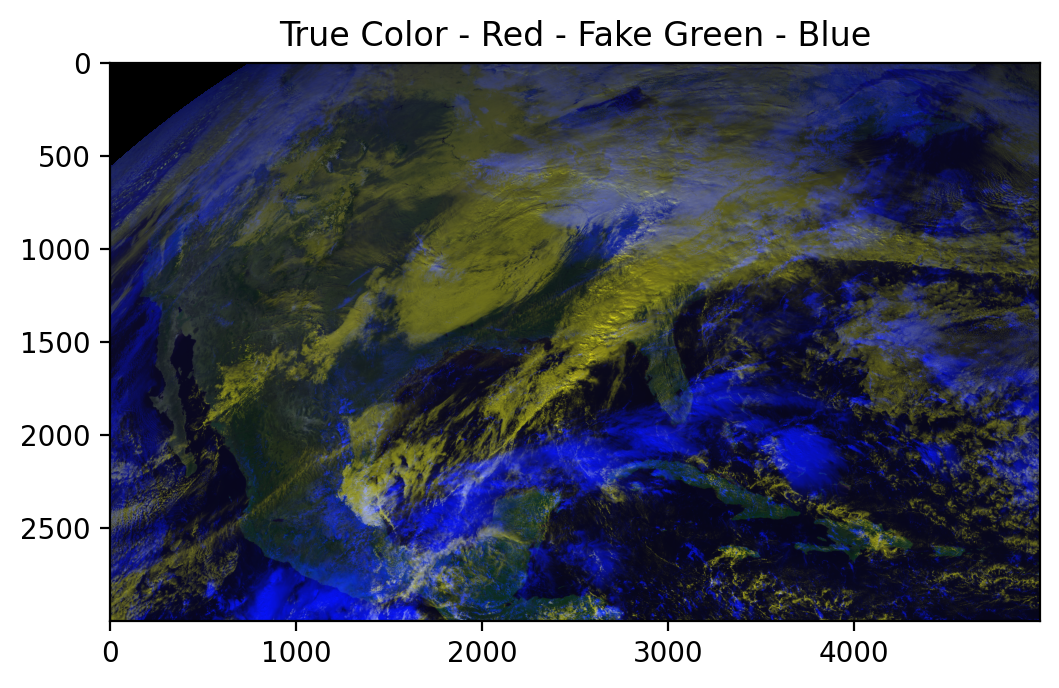

In [15]:
truecolor = np.stack([red_1km, green_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(truecolor)
plt.title('True Color - Red - Fake Green - Blue')
plt.show()

### Analysing large volume data via Dask Cluster

We may want to analyze a large collection of GOES-16 image in one time. So Dask cluster can make it really efficient to perform such analysis. 

In [16]:
import datetime
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client
from dask_gateway import GatewayCluster, Gateway

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


### Set up the Dask Client

In [2]:
# Setup a Cluster, Takes ~3min
cluster = GatewayCluster()

# Scale out to 50x Fargate workers with 2 cores and 8GB of RAM. 
#Takes ~3-5 min
cluster.scale(50)
client = cluster.get_client()
cluster

### Open an Example File and Check the Native Chunking

We want to chunk in a similar way for maximum performance

In [5]:
url = 's3://noaa-goes16/ABI-L2-RRQPEF/2021/295/19/OR_ABI-L2-RRQPEF-M6_G16_s20201811900207_e20201811909515_c20201811910042.nc'
ncfile = fsspec.open(url, anon=True)
ds = xr.open_dataset(ncfile.open())

ds.RRQPE.encoding

{'chunksizes': (226, 226),
 'fletcher32': False,
 'shuffle': False,
 'zlib': True,
 'complevel': 1,
 'source': '<File-like object S3FileSystem, noaa-goes16/ABI-L2-RRQPEF/2020/181/19/OR_ABI-L2-RRQPEF-M6_G16_s20201811900207_e20201811909515_c20201811910042.nc>',
 'original_shape': (5424, 5424),
 'dtype': dtype('int16'),
 '_Unsigned': 'true',
 '_FillValue': array([65535], dtype=uint16),
 'scale_factor': array([0.00152602], dtype=float32),
 'add_offset': array([0.], dtype=float32),
 'coordinates': 'latitude retrieval_local_zenith_angle quantitative_local_zenith_angle solar_zenith_angle t y x'}

## Open all the data from 2021-11 as a single dataset

In [8]:
%%time

s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket = 'noaa-goes16', Prefix = 'ABI-L2-RRQPEF/2021/11')

@dask.delayed
def s3open_data(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    f = fs.open(path)
    ds = xr.open_dataset(f) 
    return ds['RRQPE'].values


files_mapper = [s3open_data("s3://noaa-goes16/" + file['Key']) for page in page_iterator for file in page['Contents']]

CPU times: user 424 ms, sys: 28.5 ms, total: 453 ms
Wall time: 644 ms


In [9]:
# how many files did we load?

len(files_mapper)

1440

In [10]:
%%time
shape = ds.RRQPE.shape
dtype = ds.RRQPE.dtype
data_mapper = [dask.array.from_delayed(f, shape, dtype=dtype) for f in files_mapper]
all_data = dask.array.stack(data_mapper)
all_data

CPU times: user 364 ms, sys: 199 µs, total: 364 ms
Wall time: 403 ms


dask.array<stack, shape=(1440, 5424, 5424), dtype=float32, chunksize=(1, 5424, 5424), chunktype=numpy.ndarray>

In [11]:
%%time 

with performance_report(filename="dask-report.html"):
    all_data_sum = dask.array.nansum(all_data, axis=0).compute()

CPU times: user 2.84 s, sys: 226 ms, total: 3.07 s
Wall time: 35.7 s


## Convert units from mm/h to mm

In [12]:
all_data_sum = all_data_sum * (1.0 / 6.0)

### Plot Accumulated Preciptation data

Text(0.5, 1.0, 'Precipitation Accumulation 2020-01')

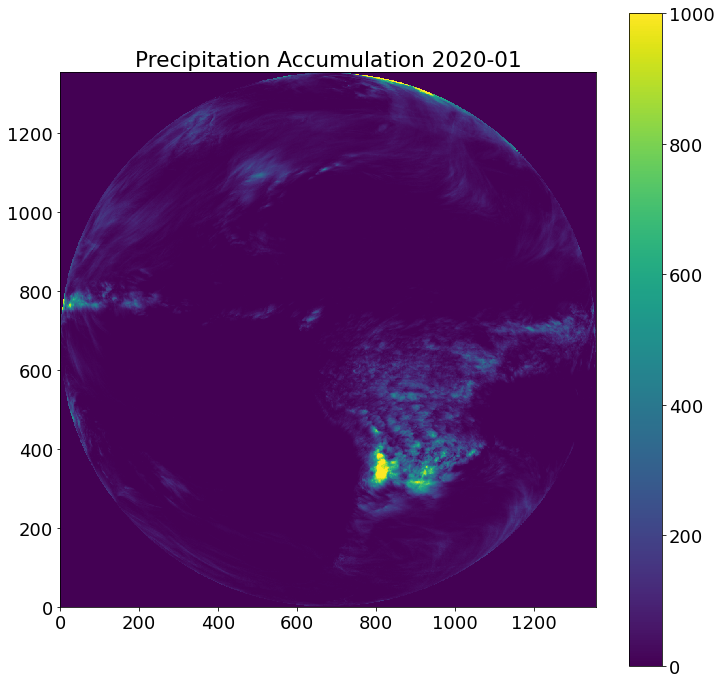

In [16]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
pc = ax.pcolormesh(all_data_sum[::-4, ::4])
plt.colorbar(pc)
pc.set_clim([0, 1500])
plt.title('Precipitation Accumulation 2021-11')

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [17]:
cluster.shutdown()